In [1]:
import pandas as pd
import math, json, sys
import numpy as np
import seaborn as sns
from sklearn import preprocessing, cross_validation, svm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from matplotlib import style

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'
style.use('ggplot')

/usr/local/apps/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
df_train = pd.read_csv('../data/train.csv')
df_test = df_test_o = pd.read_csv('../data/test.csv')

In [3]:
schema = json.loads(open('../schema.old.json', 'r').read())

In [4]:
def columns_by_type(t):
    cols = []
    for col in schema:
        if schema[col]['type'] == t and not col == 'SalePrice':
            cols.append(col)
    return cols

In [5]:
numeric_cols = columns_by_type('NUMERIC')

print len(numeric_cols),'numeric cols'
print numeric_cols

35 numeric cols
[u'3SsnPorch', u'ScreenPorch', u'BsmtFullBath', u'2ndFlrSF', u'HalfBath', u'MoSold', u'OverallCond', u'LotArea', u'GrLivArea', u'WoodDeckSF', u'EnclosedPorch', u'1stFlrSF', u'LotFrontage', u'MiscVal', u'YearRemodAdd', u'OverallQual', u'KitchenAbvGr', u'BsmtFinSF1', u'BsmtHalfBath', u'TotalBsmtSF', u'BsmtFinSF2', u'TotRmsAbvGrd', u'MasVnrArea', u'OpenPorchSF', u'LowQualFinSF', u'BsmtUnfSF', u'GarageYrBlt', u'FullBath', u'PoolArea', u'BedroomAbvGr', u'YrSold', u'Fireplaces', u'GarageArea', u'GarageCars', u'YearBuilt']


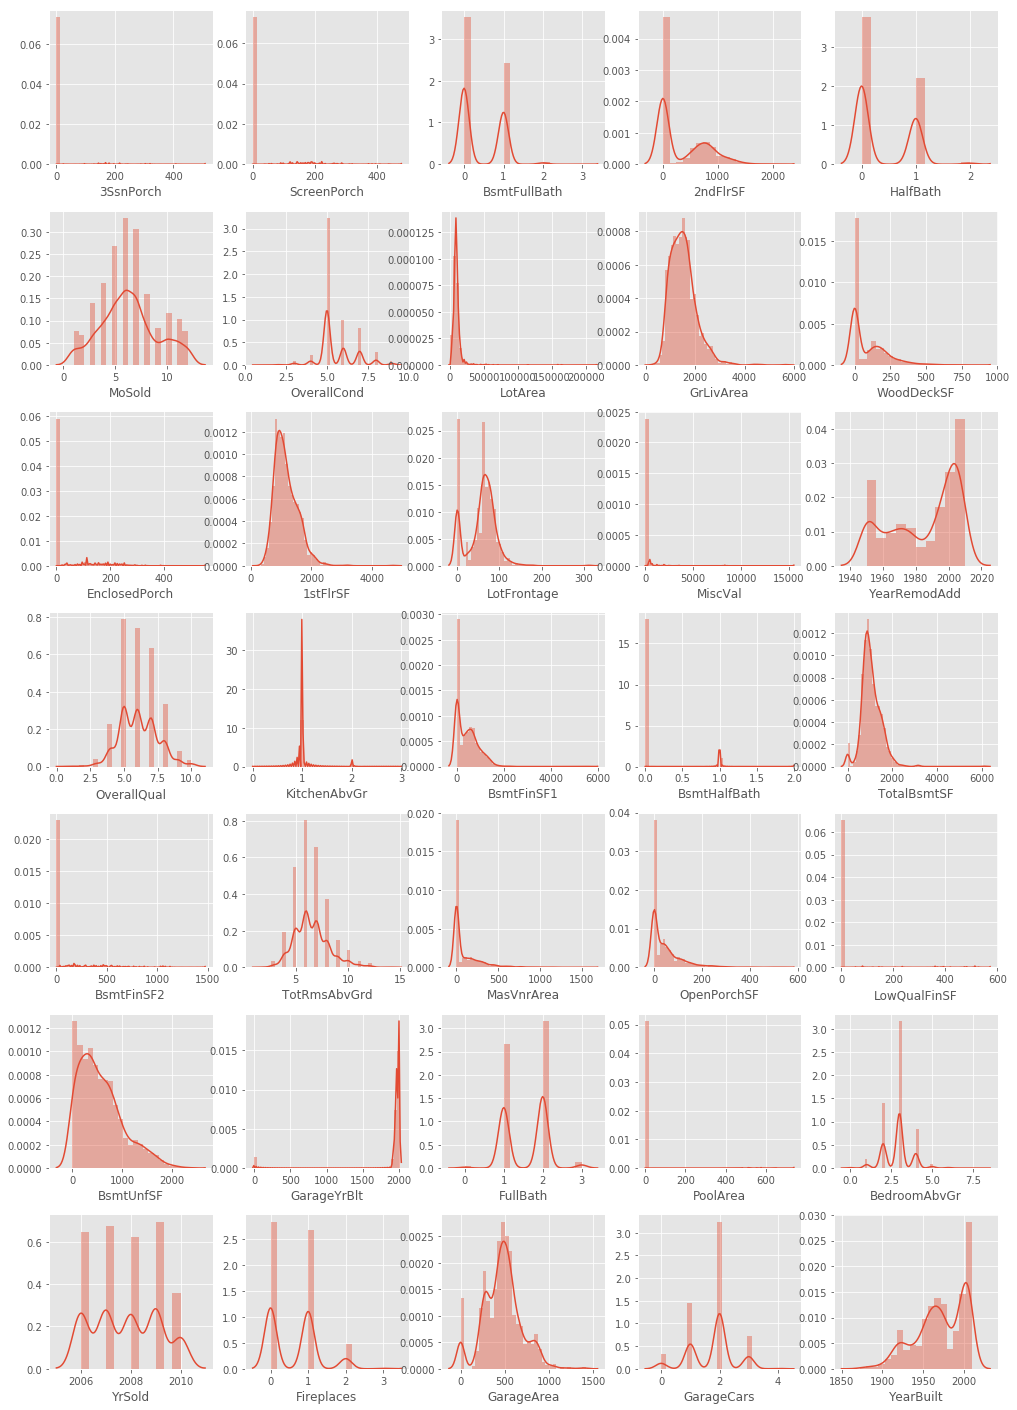

In [6]:
nCols = 5
nRows = 7
fig, axs = plt.subplots(nRows, nCols, figsize=(17, 25))
plt.subplots_adjust(hspace=.3)

df_train.fillna(0,inplace=True)

for idx in range(len(numeric_cols)):
    colname = numeric_cols[idx]
    row = idx/nCols
    col = idx - row*nCols
    sns.distplot(df_train[colname], label=colname, ax=axs[row, col])

In [7]:
for col in ['GrLivArea', 'LotArea']:
    print col
    print 'train:', df_train[col].max()
    print 'test:', df_test[col].max()

GrLivArea
train: 5642
test: 5095
LotArea
train: 215245
test: 56600


### OUTLIERS

In [8]:
outliers_LotArea = df_train['LotArea'][df_train['LotArea']>100000]
print outliers_LotArea

249    159000
313    215245
335    164660
706    115149
Name: LotArea, dtype: int64


In [9]:
# dropping 4 records
df_train = df_train.drop(outliers_LotArea.index)
print len(df_train)

1456


### NORMALIZATION (LOG)

In [10]:
def logify_and_show(col):
    df_train[col] = np.log(df_train[col])
    df_test[col] = np.log(df_test[col])
    sns.distplot(df_train[col])

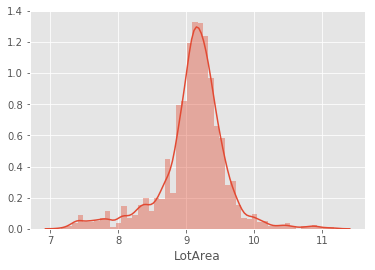

In [11]:
logify_and_show('LotArea')

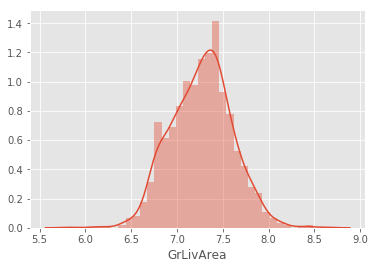

In [12]:
logify_and_show('GrLivArea')

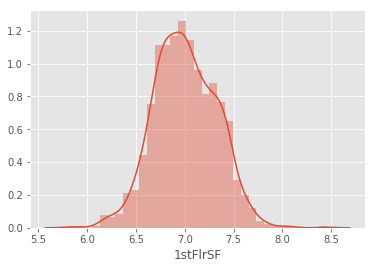

In [13]:
logify_and_show('1stFlrSF')

### PoolArea

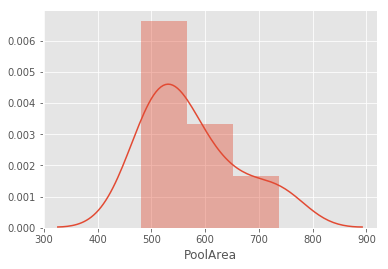

In [14]:
sns.distplot(df_train['PoolArea'][df_train['PoolArea']>0])

Maybe what's really important is whether there is a pool or not, not necesarily how big it really is.

In [15]:
def hasPool(row):
    return 0 if row['PoolArea'] == 0 else 1

df_train['HasPool'] = df_train.apply(hasPool, axis=1)
df_test['HasPool'] = df_test.apply(hasPool, axis=1)

print df_train.groupby('HasPool')['Id'].nunique()
print df_test.groupby('HasPool')['Id'].nunique()

HasPool
0    1449
1       7
Name: Id, dtype: int64
HasPool
0    1453
1       6
Name: Id, dtype: int64


Now let's have a look at the CATEGORICAL and BINARY features.

In [16]:
binary_cols = columns_by_type('BINARY')

print len(binary_cols),'binary cols'
print binary_cols

for bcol in binary_cols:
    print df_train.groupby(bcol)['Id'].nunique()

2 binary cols
[u'CentralAir', u'Street']
CentralAir
N      95
Y    1361
Name: Id, dtype: int64
Street
Grvl       5
Pave    1451
Name: Id, dtype: int64


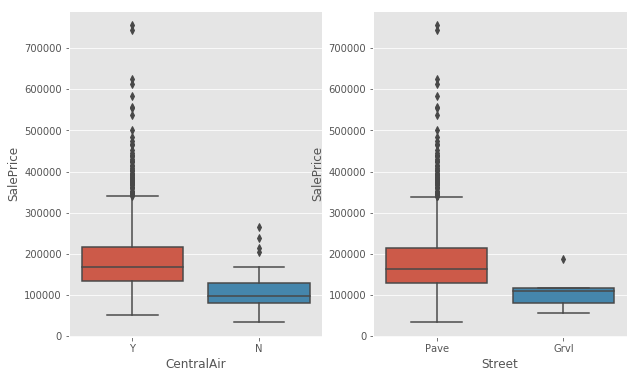

In [17]:
f, axs = plt.subplots(1,2, figsize=(10, 6))

for i in range(len(binary_cols)):
    c = binary_cols[i]
    data = pd.concat([df_train['SalePrice'], df_train[c]], axis=1)
    fig = sns.boxplot(x=c, y='SalePrice', data=data,ax=axs[int(i)])

In [18]:
def isCentralAir(row):
    return 0 if row['CentralAir'] == 'Y' else 1

df_train['CentralAirY'] = df_train.apply(isCentralAir, axis=1)
df_test['CentralAirY'] = df_test.apply(isCentralAir, axis=1)

print df_train.groupby('CentralAirY')['Id'].nunique()
print df_test.groupby('CentralAirY')['Id'].nunique()

CentralAirY
0    1361
1      95
Name: Id, dtype: int64
CentralAirY
0    1358
1     101
Name: Id, dtype: int64


In [19]:
def isPavedStreet(row):
    return 0 if row['Street'] == 'Pave' else 1

df_train['PavedStreetY'] = df_train.apply(isPavedStreet, axis=1)
df_test['PavedStreetY'] = df_test.apply(isPavedStreet, axis=1)

print df_train.groupby('PavedStreetY')['Id'].nunique()
print df_test.groupby('PavedStreetY')['Id'].nunique()

PavedStreetY
0    1451
1       5
Name: Id, dtype: int64
PavedStreetY
0    1453
1       6
Name: Id, dtype: int64


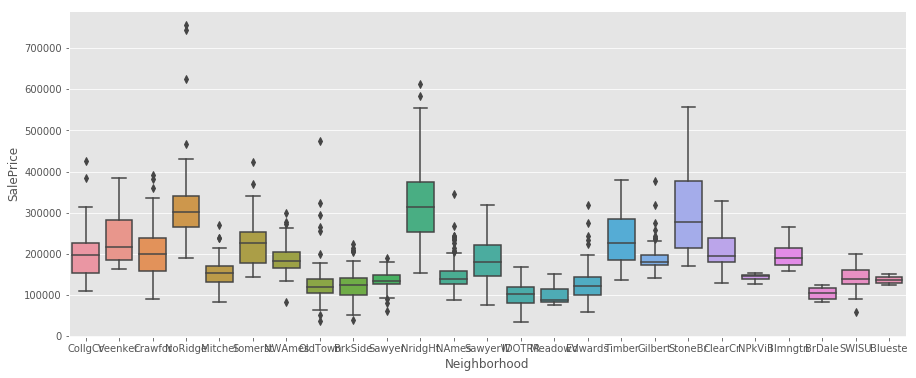

In [20]:
f, axs = plt.subplots(1,1, figsize=(15, 6))
c = 'Neighborhood'
data = pd.concat([df_train['SalePrice'], df_train[c]], axis=1)
fig = sns.boxplot(x=c, y='SalePrice', data=data)

In [21]:
categorical_cols = columns_by_type('CATEGORICAL')

print len(categorical_cols),'categorical cols'
print categorical_cols

for ccol in categorical_cols:
    print '>>>>>>>>>>>>>>>>',df_train.groupby(ccol)['Id'].nunique()

42 categorical cols
[u'MasVnrType', u'LandSlope', u'GarageQual', u'Exterior1st', u'GarageFinish', u'Electrical', u'BsmtQual', u'BsmtExposure', u'Foundation', u'GarageCond', u'BsmtCond', u'HeatingQC', u'LotShape', u'MiscFeature', u'PavedDrive', u'Utilities', u'SaleType', u'LotConfig', u'MSZoning', u'Exterior2nd', u'Heating', u'MSSubClass', u'PoolQC', u'FireplaceQu', u'KitchenQual', u'BsmtFinType2', u'BsmtFinType1', u'Condition2', u'Condition1', u'GarageType', u'LandContour', u'Neighborhood', u'Fence', u'SaleCondition', u'BldgType', u'ExterQual', u'Functional', u'Alley', u'RoofStyle', u'HouseStyle', u'ExterCond', u'RoofMatl']
>>>>>>>>>>>>>>>> MasVnrType
0            8
BrkCmn      14
BrkFace    445
None       862
Stone      127
Name: Id, dtype: int64
>>>>>>>>>>>>>>>> LandSlope
Gtl    1382
Mod      65
Sev       9
Name: Id, dtype: int64
>>>>>>>>>>>>>>>> GarageQual
0       81
Ex       3
Fa      48
Gd      14
Po       3
TA    1307
Name: Id, dtype: int64
>>>>>>>>>>>>>>>> Exterior1st
AsbShng   

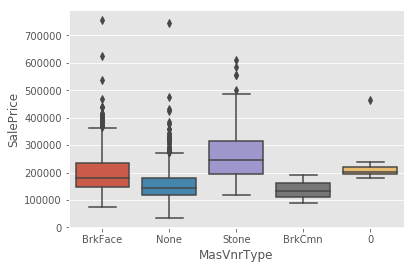

In [22]:
c = 'MasVnrType'
data = pd.concat([df_train['SalePrice'], df_train[c]], axis=1)
#sns.distplot(df_train['LandSlope'])
sns.boxplot(x=c, y='SalePrice', data=data)

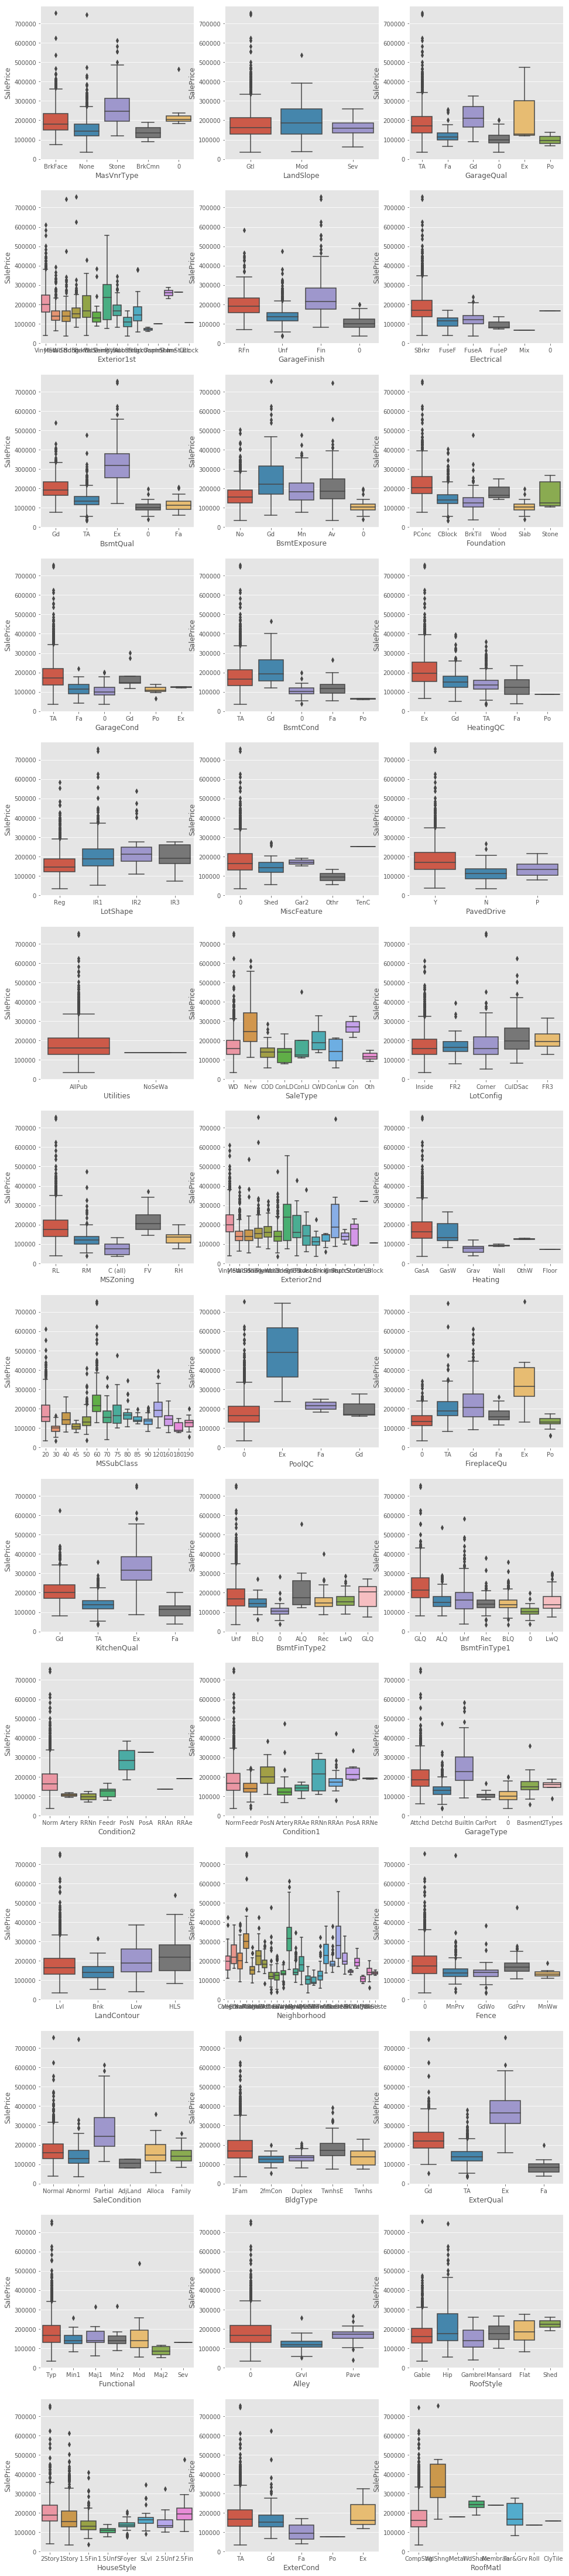

In [23]:
# this one takes a while
nCols=3
nRows=14
fig, axs = plt.subplots(nRows, nCols, figsize=(16, 80))

for idx in range(len(categorical_cols)):
    c = categorical_cols[idx]
    row = idx / nCols
    col = idx - row*nCols
    data = pd.concat([df_train['SalePrice'], df_train[c]], axis=1)
    sns.boxplot(x=c, y='SalePrice', data=data, ax=axs[row, col])

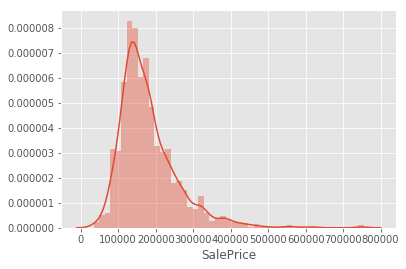

In [24]:
sns.distplot(df_train['SalePrice'])

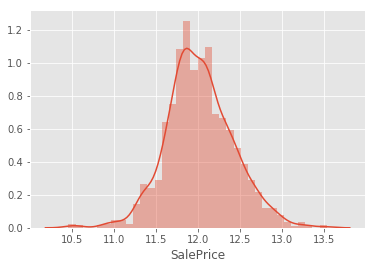

In [25]:
df_train['SalePrice'] = np.log(df_train['SalePrice'])
sns.distplot(df_train['SalePrice'])

In [26]:
df_train['DateSold']=df_train['YrSold']+df_train['MoSold']/12.0
df_train['DateSold'].head()

SyntaxError: invalid syntax (<ipython-input-26-72dd25d1d7cb>, line 1)

In [ ]:
print df_train['MSSubClass'].head()
print df_train['MSSubClass'].dtype

In [ ]:
df_train.to_csv('train_transformed.csv', sep=',', index=False)
df_test.to_csv('test_transformed.csv', sep=',', index=False)

In [33]:
df_train[['Id','LotArea']].head()

,Id,LotArea
0,1,9.041922
1,2,9.169518
2,3,9.328123
3,4,9.164296
4,5,9.565214
